In [422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.signal import butter, find_peaks, filtfilt, iirnotch
from scipy.signal import detrend
import pywt

In [457]:
df = pd.read_csv("../data/orangepi/ecg_w_phys/record_1.csv")
df.head()

,time,y1,y2,y3
0,0.006093,2253,367,1922
1,0.008843,2192,1957,2752
2,0.011578,1473,3345,2033
3,0.014305,511,2612,2979
4,0.017035,14,4095,2290


In [458]:
def bandpass_filter(ecg_signal, fs, lowcut=0.5, highcut=40.0, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

def bandstop_filter(ecg_signal, fs, lowcut=0.5, highcut=40.0, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

def notch_filter(ecg_signal, freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    notch_freq = freq / nyquist
    b, a = iirnotch(notch_freq, quality_factor, fs)
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

def wavelet_denoise(ecg_signal, wavelet='db6', level=4, threshold_mode="soft"):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(ecg_signal)))
    denoised_coeffs = [pywt.threshold(c, threshold, mode=threshold_mode) for c in coeffs]
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

def normalize_signal(ecg_signal):
    mean = np.mean(ecg_signal)
    std = np.std(ecg_signal)
    normalized_signal = (ecg_signal - mean) / std
    return normalized_signal

def crop(ecg_signal, interval, ts, tf):
    ts_i = np.argwhere(interval >= ts)[0][0]
    tf_i = np.argwhere(interval >= tf)[0][0]
    return ecg_signal[ts_i: tf_i], interval[ts_i: tf_i]

370


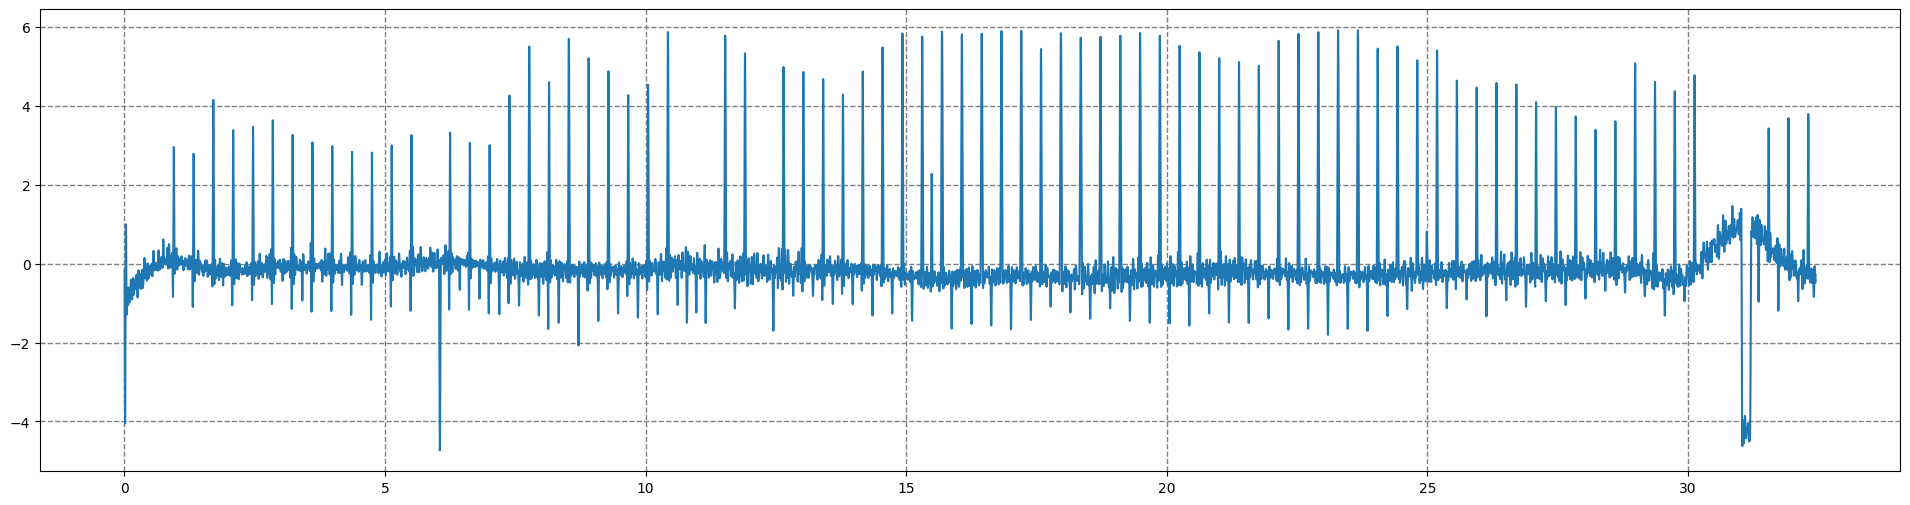

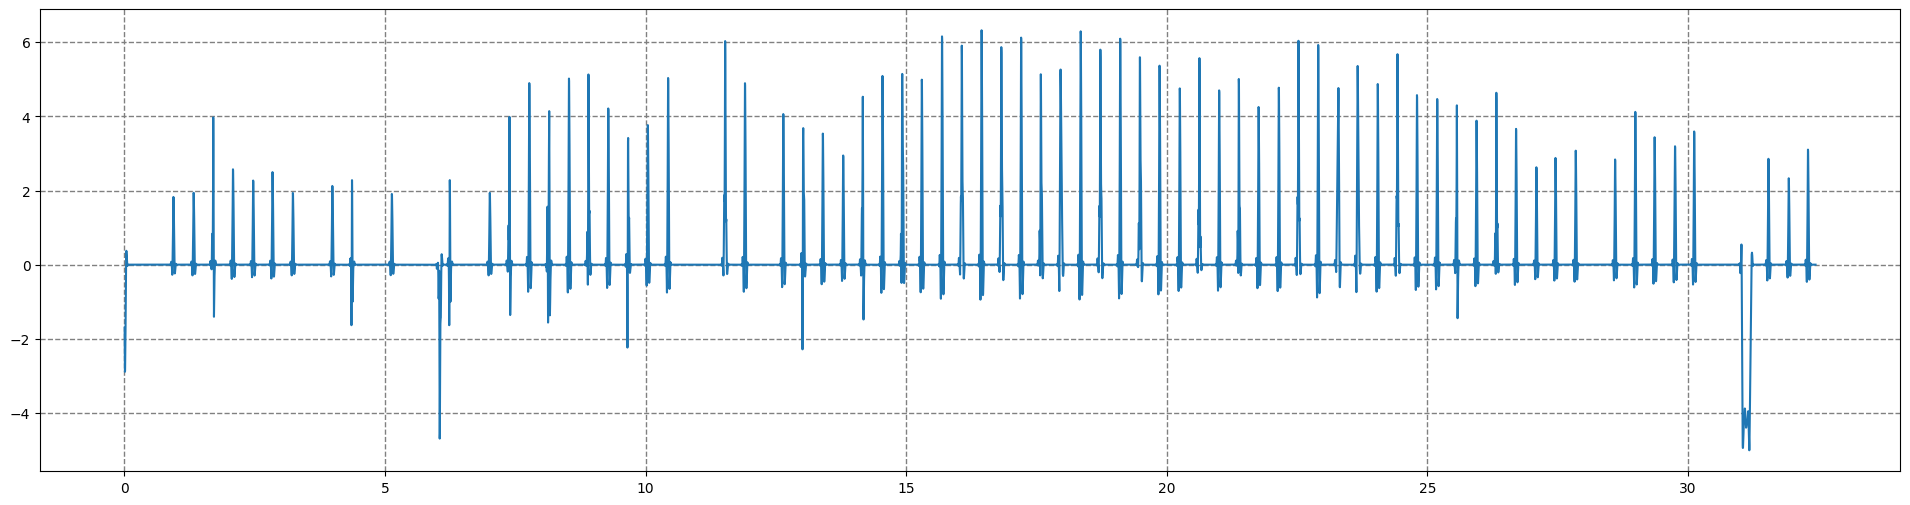

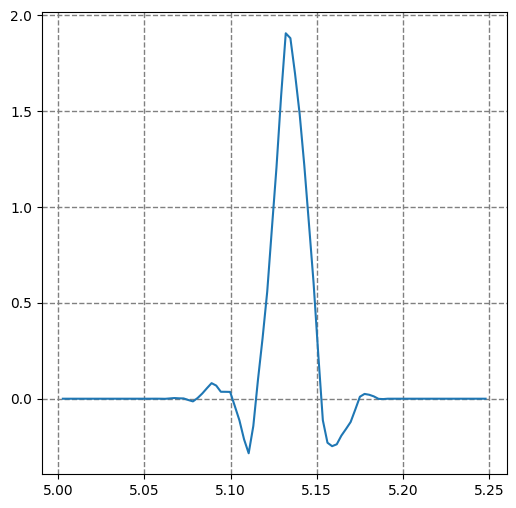

In [463]:
x = df["time"].to_numpy()
y = df["y1"].to_numpy() * (3.3 - 0.15) / 65535
# y, x = crop(y.copy(), x.copy(), 5, 18)

freq = int((1 / (x[1:] - x[:-1])).mean())
print(freq)

y = detrend(y)
y = bandpass_filter(y.copy(), freq)
y = notch_filter(y.copy(), freq, 50)
y = notch_filter(y.copy(), freq, 60)
y = notch_filter(y.copy(), freq, 100)
y = notch_filter(y.copy(), freq, 120)
y = normalize_signal(y.copy())

plt.figure(figsize=(24, 6))
plt.plot(x, y[:x.shape[0]])
plt.grid(linestyle="--", linewidth=1, c="gray")
plt.show()

# 'garotte', 'garrote', 'greater', 'hard', 'less', 'soft'.
# db6, sym4, coif5

y = wavelet_denoise(y.copy(), "sym4", 3, "hard")

plt.figure(figsize=(24, 6))
plt.plot(x, y[:x.shape[0]])
plt.grid(linestyle="--", linewidth=1, c="gray")
plt.show()
# 
yd, xd = crop(y[:x.shape[0]], x[:x.shape[0]], 5, 5.25)
plt.figure(figsize=(6, 6))
plt.plot(xd, yd)
plt.grid(linestyle="--", linewidth=1, c="gray")
plt.show()

In [426]:
def detect_r_peaks(ecg_signal, distance=200, height=None):
    peaks, _ = find_peaks(ecg_signal, distance=distance, height=height)
    return peaks

def segment_signal(ecg_signal, segment_length, overlap):
    segments = []
    step = segment_length - overlap
    for start in range(0, len(ecg_signal) - segment_length + 1, step):
        segment = ecg_signal[start:start + segment_length]
        segments.append(segment)
    return segments
def plot_segments(segments, fs):
    """
    Plots the segmented ECG signal.

    Parameters:
    segments (list): List of ECG signal segments.
    fs (int): Sampling frequency in Hz.
    """
    num_segments = len(segments)
    time_axis = np.arange(len(segments[0])) / fs

    plt.figure(figsize=(12, num_segments * 2))
    for i, segment in enumerate(segments):
        plt.subplot(num_segments, 1, i + 1)
        plt.plot(time_axis, segment)
        plt.title(f'Segment {i+1}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.tight_layout()

    plt.show()


(37,)


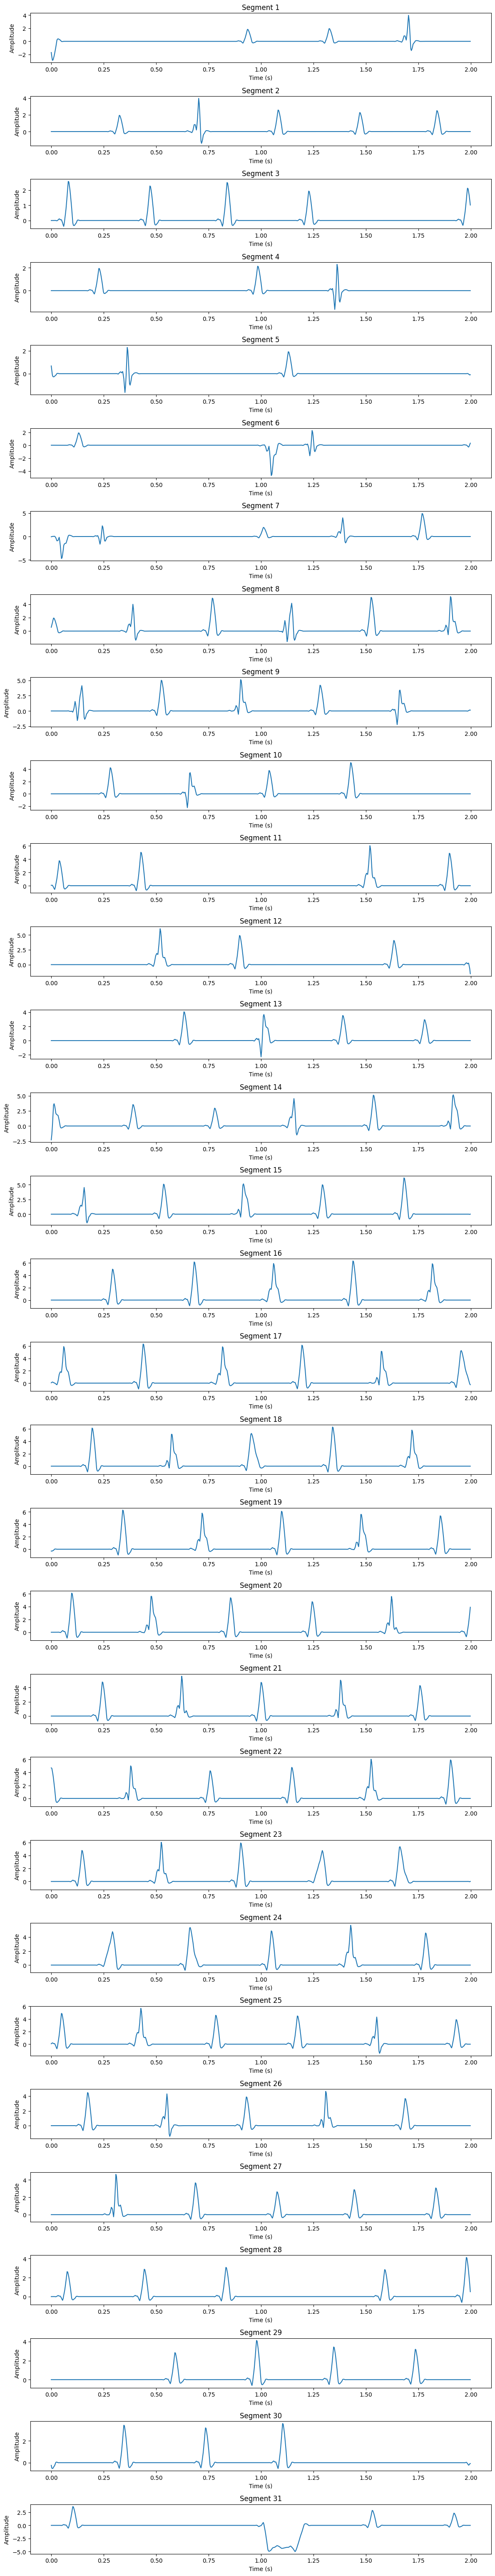

In [427]:
peaks = detect_r_peaks(y)
print(peaks.shape)
segments = segment_signal(y, 2 * freq, freq)
plot_segments(segments, freq)

In [428]:
class EmgPreprocessing:
    def __init__(self, x, y, kf: float = None) -> None:
        self.x = x
        self.y = y * kf if kf is not None else y  #* (3100 - 150) / 1000 / 65535
    
    def baseline(self, time_point: float = None):
        baseline_idx = np.argwhere(self.x >= time_point)[0][0]
        baseline = self.y[:baseline_idx]
        x0 = np.mean(baseline, axis=0)
        normalize = self.y - x0
        yf = np.argwhere(self.x >= 22)[0][0]

        self.x = self.x[baseline_idx:yf]
        self.y = normalize[baseline_idx:yf]
        return self
    
    def bandpass(self, sfreq: float = 1000, low: float = 450, high: float = 20):
        high = high/(sfreq/2)
        low = low/(sfreq/2)
        b, a = butter(4, [high, low], btype='bandpass')
        self.y = filtfilt(b, a, self.y)
        return self
    
    def notch(self, freq: float = 50, sfreq: float = 1000):
        b, a = iirnotch(freq, 30.0, sfreq)
        self.y = filtfilt(b, a, self.y)
        return self
    
    def lowpass(self, sfreq: float = 1000, low: float = 10):
        low = low/(sfreq/2)
        b, a = butter(4, low, btype='lowpass')
        self.y = filtfilt(b, a, self.y)
        return self
    
    def rectification(self):
        self.y = np.abs(self.y)
        return self
    
    def power(self, mode) -> np.ndarray:
        if mode == "simps":
            return simpson(np.power(self.y, 2))

        if mode == "rms":
            return np.sqrt(np.mean(np.power(self.y, 2)))

        return simpson(np.power(self.y, 2))

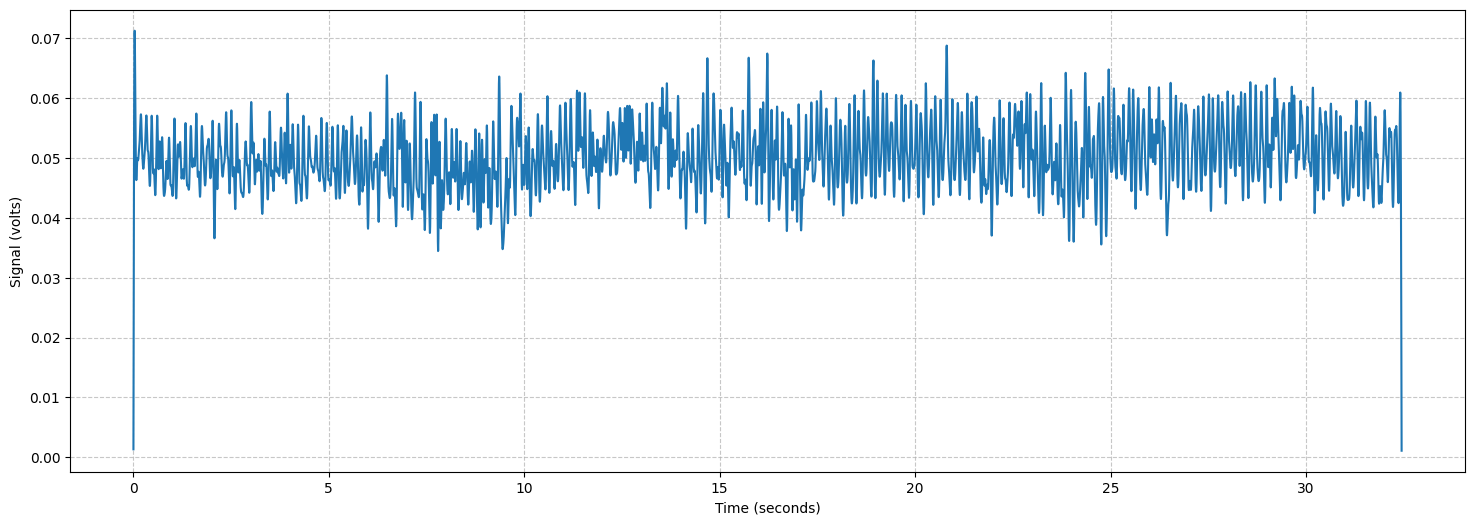

In [443]:
process = EmgPreprocessing(x, df["y2"].to_numpy(), 3.15 / 65535)
process.bandpass(1000, 400, 15).notch().rectification().lowpass(1000, 40)

plt.figure(figsize=(18, 6))
plt.plot(process.x, process.y)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal (volts)")
plt.show()